In [1]:
# 导入需要的包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
import torchvision.transforms as transforms
import torchvision.io 
import librosa
from PIL import Image
import albumentations as alb
import torch.multiprocessing as mp
import warnings

warnings.filterwarnings('ignore')
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping
import torch.nn as nn
from torch.nn.functional import cross_entropy
import torchmetrics
import timm
from pathlib import Path


In [2]:
class Config:
    num_classes = 264  # 鸟叫种类
    batch_size = 12  
    PRECISION = 16  # 数据精度 
    seed = 2023
    model = "tf_efficientnet_b1_ns"
    pretrained = False
    use_mixup = False
    mixup_alpha = 0.2   
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

    data_root = "/kaggle/input/birdclef-2023/"
    train_images = "/kaggle/input/split-creating-melspecs-stage-1/specs/train/"
    valid_images = "/kaggle/input/split-creating-melspecs-stage-1/specs/valid/"
    train_path = "/kaggle/input/bc2023-train-val-df/train.csv"
    valid_path = "/kaggle/input/bc2023-train-val-df/valid.csv"
    
    test_path = '/kaggle/input/birdclef-2023/test_soundscapes/'
    SR = 32000  # 采样参数
    DURATION = 5
    LR = 5e-4
    
    model_ckpt = '/kaggle/input/exp2-b1-maxs7/exp1/last.ckpt'  # 在数据上预训练的checkpoint
#     model_ckpt = '/kaggle/input/birdclef-balance/last_balance.ckpt'

In [3]:
pl.seed_everything(Config.seed, workers=True)

2023

In [4]:
def config_to_dict(cfg):
    return dict((name, getattr(cfg, name)) for name in dir(cfg) if not name.startswith('__'))

In [5]:
def compute_melspec(y, sr, n_mels, fmin, fmax):  # 把数据转化成梅尔谱
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = lb.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax,
    )

    melspec = lb.power_to_db(melspec).astype(np.float32)
    return melspec

def mono_to_color(X, eps=1e-6, mean=None, std=None):  # 把音频梅尔谱转化成视觉图像
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def crop_or_pad(y, length, is_train=True, start=None):  # 对齐音频长度
    if len(y) < length:
        y = np.concatenate([y, np.zeros(length - len(y))])
        
        n_repeats = length // len(y)
        epsilon = length % len(y)
        
        y = np.concatenate([y]*n_repeats + [y[:epsilon]])
        
    elif len(y) > length:
        if not is_train:
            start = start or 0
        else:
            start = start or np.random.randint(len(y) - length)

        y = y[start:start + length]

    return y


In [6]:
df_train = pd.read_csv(Config.train_path)
Config.num_classes = len(df_train.primary_label.unique())

In [7]:
df_test = pd.DataFrame(
     [(path.stem, *path.stem.split("_"), path) for path in Path(Config.test_path).glob("*.ogg")],
    columns = ["filename", "name" ,"id", "path"]
)
print(df_test.shape)
df_test.head()

(1, 4)


,filename,name,id,path
0,soundscape_29201,soundscape,29201,/kaggle/input/birdclef-2023/test_soundscapes/s...


In [8]:
# df_test = pd.concat([df_test,df_test,df_test]).reset_index(drop=True)

In [9]:
import albumentations as A
def get_train_transform():  # 对音频进行变换
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
                A.Cutout(max_h_size=5, max_w_size=16),
                A.CoarseDropout(max_holes=4),
            ], p=0.5),
    ])

In [10]:
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile 

class BirdDataset(Dataset):
    def __init__(self, data, sr=Config.SR, n_mels=128, fmin=0, fmax=None, duration=Config.DURATION, step=None, res_type="kaiser_fast", resample=True):
        
        self.data = data
        
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr//2

        self.duration = duration
        self.audio_length = self.duration*self.sr
        self.step = step or self.audio_length
        
        self.res_type = res_type
        self.resample = resample

    def __len__(self):
        return len(self.data)
    
    @staticmethod
    def normalize(image):  # 图像的归一化函数
        image = image.astype("float32", copy=False) / 255.0
        image = np.stack([image, image, image])
        return image
    
    
    def audio_to_image(self, audio):  # 音频转成图像
        melspec = compute_melspec(audio, self.sr, self.n_mels, self.fmin, self.fmax) 
        image = mono_to_color(melspec)
        image = self.normalize(image)
        return image

    def read_file(self, filepath):  
        audio, orig_sr = sf.read(filepath, dtype="float32")

        if self.resample and orig_sr != self.sr:  # 音频采样
            audio = lb.resample(audio, orig_sr, self.sr, res_type=self.res_type)
          
        audios = []
        for i in range(self.audio_length, len(audio) + self.step, self.step):  # 音频分帧
            start = max(0, i - self.audio_length)
            end = start + self.audio_length
            audios.append(audio[start:end])
            
        if len(audios[-1]) < self.audio_length:
            audios = audios[:-1]
            
        images = [self.audio_to_image(audio) for audio in audios]  # 音频转成图像
        images = np.stack(images)
        
        return images
    
        
    def __getitem__(self, idx):
        return self.read_file(self.data.loc[idx, "path"])

In [11]:
ds_test = BirdDataset(
    df_test, 
    sr = Config.SR,
    duration = Config.DURATION,
)



In [12]:
ds_test[0].shape

(120, 3, 128, 313)

In [13]:
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):  # 展示图像来检查是否在载入正确
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds), num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img = img_ds[img_index][0]   
        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
            
        title = f"Spec"
        ax.set_title(title)  

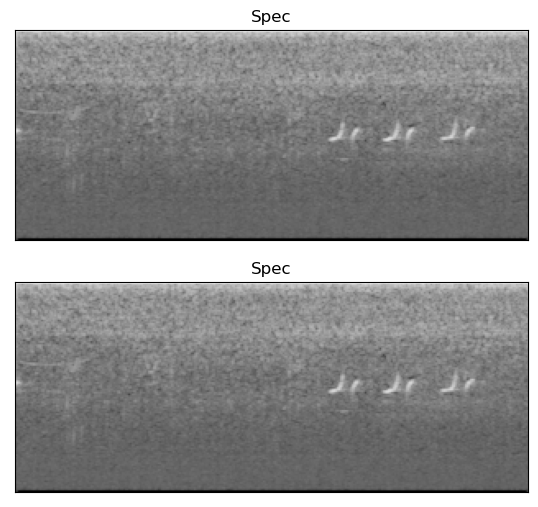

In [14]:
show_batch(ds_test, 2, 2, 1)

In [15]:
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR

def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(  # 对需要更新梯度的参数采用adam优化器
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=Config.weight_decay
        )
    interval = "epoch"
    
    lr_scheduler = CosineAnnealingWarmRestarts(  # 采用余弦退火来更新lr
                            model_optimizer, 
                            T_0=Config.epochs, 
                            T_mult=1, 
                            eta_min=1e-6, 
                            last_epoch=-1
                        )

    return {
        "optimizer": model_optimizer, 
        "lr_scheduler": {
            "scheduler": lr_scheduler,
            "interval": interval,
            "monitor": "val_loss",
            "frequency": 1
        }
    }

In [16]:
import sklearn.metrics

def padded_cmap(solution, submission, padding_factor=5):  # 指标cmAP的计算
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

def map_score(solution, submission):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    score = sklearn.metrics.average_precision_score(
        solution.values,
        submission.values,
        average='micro',
    )
    return score

In [17]:
class BirdClefModel(pl.LightningModule):
    def __init__(self, model_name=Config.model, num_classes = Config.num_classes, pretrained = Config.pretrained):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if 'res' in model_name:
            self.in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(self.in_features, num_classes)
        elif 'dense' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(self.in_features, num_classes)
        elif 'efficientnet' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.Linear(self.in_features, num_classes)
            )
        
        self.loss_function = nn.BCEWithLogitsLoss() 

    def forward(self,images):
        logits = self.backbone(images)
        return logits
        
    def configure_optimizers(self):
        return get_optimizer(lr=Config.LR, params=self.parameters())

    def training_step(self, batch, batch_idx):
        image, target = batch        

        y_pred = self(image)
        loss = self.loss_function(y_pred,target)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        image, target = batch     
        y_pred = self(image)
        val_loss = self.loss_function(y_pred, target)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        
        return {"val_loss": val_loss, "logits": y_pred, "targets": target}
    
    def train_dataloader(self):
        return self._train_dataloader 
    
    def validation_dataloader(self):
        return self._validation_dataloader
    
    def validation_epoch_end(self,outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        output_val = torch.cat([x['logits'] for x in outputs],dim=0).sigmoid().cpu().detach().numpy()
        target_val = torch.cat([x['targets'] for x in outputs],dim=0).cpu().detach().numpy()
        
        # print(output_val.shape)
        val_df = pd.DataFrame(target_val, columns = birds)
        pred_df = pd.DataFrame(output_val, columns = birds)
        
        avg_score = padded_cmap(val_df, pred_df, padding_factor = 5)
        avg_score2 = padded_cmap(val_df, pred_df, padding_factor = 3)
        avg_score3 = sklearn.metrics.label_ranking_average_precision_score(target_val,output_val)
        
#         competition_metrics(output_val,target_val)
        print(f'epoch {self.current_epoch} validation loss {avg_loss}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 5 {avg_score}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 3 {avg_score2}')
        print(f'epoch {self.current_epoch} validation AP score {avg_score3}')
        
        
        val_df.to_pickle('val_df.pkl')
        pred_df.to_pickle('pred_df.pkl')
        
        
        return {'val_loss': avg_loss,'val_cmap':avg_score}
    
    
    
    

In [18]:
def predict(data_loader, model):  # 对测试集产生预测
        
    model.to('cpu')
    model.eval()    
    predictions = []
    for en in range(len(ds_test)):
        print(en)
        images = torch.from_numpy(ds_test[en])
        print(images.shape)
        with torch.no_grad():
            outputs = model(images).sigmoid().detach().cpu().numpy() / 10
            print(outputs.shape)
#             pred_batch.extend(outputs.detach().cpu().numpy())
#         pred_batch = np.vstack(pred_batch)
        predictions.append(outputs)
            
    
    return predictions

In [19]:
# import pickle
# raw_data = open(Config.model_ckpt, 'rb')
# data = pickle.load(raw_data)
# print(data.keys())

In [20]:
import gc

print(f"Create Dataloader...")

ds_test = BirdDataset(
    df_test, 
    sr = Config.SR,
    duration = Config.DURATION,
)


audio_model = BirdClefModel()

print("Model Creation")

model = BirdClefModel.load_from_checkpoint(Config.model_ckpt, train_dataloader=None,validation_dataloader=None, strict=False) 
print("Running Inference..")

preds = predict(ds_test, model)  # 直接进行推理

gc.collect()
torch.cuda.empty_cache()


Create Dataloader...
Model Creation
Running Inference..
0
torch.Size([120, 3, 128, 313])
(120, 264)


In [21]:
filenames = df_test.filename.values.tolist()

bird_cols = list(pd.get_dummies(df_train['primary_label']).columns)
sub_df = pd.DataFrame(columns=['row_id']+bird_cols)

In [22]:
sub_df

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1


# Generate Submission csv

In [23]:
for i, file in enumerate(filenames):  # 生成提交csv
    pred = preds[i] 
    num_rows = len(pred)
    row_ids = [f'{file}_{(i+1)*5}' for i in range(num_rows)]
    df = pd.DataFrame(columns=['row_id']+bird_cols)
    
    df['row_id'] = row_ids
    df[bird_cols] = pred
    
    sub_df = pd.concat([sub_df,df]).reset_index(drop=True)
    

In [24]:
sub_df

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,soundscape_29201_5,0.030490,0.033229,0.059804,0.002762,0.010509,0.027278,0.020175,0.014711,0.063576,...,0.006567,0.001610,0.008345,0.003915,0.005110,0.022659,0.012035,0.005087,0.004334,0.027794
1,soundscape_29201_10,0.042934,0.082372,0.010497,0.028489,0.016535,0.012001,0.012454,0.007244,0.002166,...,0.001995,0.001899,0.062509,0.006304,0.004285,0.016614,0.001907,0.002533,0.000608,0.003157
2,soundscape_29201_15,0.071034,0.086588,0.036202,0.001823,0.001130,0.064040,0.000889,0.000804,0.002170,...,0.001065,0.001012,0.051398,0.005267,0.002435,0.003192,0.000274,0.008678,0.002611,0.006419
3,soundscape_29201_20,0.005382,0.036507,0.011471,0.017000,0.027739,0.018746,0.013852,0.005758,0.006596,...,0.010016,0.029099,0.040412,0.050717,0.020279,0.025011,0.002257,0.006110,0.005520,0.005308
4,soundscape_29201_25,0.017004,0.059552,0.034368,0.021735,0.046454,0.060372,0.029676,0.028365,0.016750,...,0.034540,0.040234,0.033768,0.052319,0.033181,0.030464,0.017710,0.027007,0.032184,0.017763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,soundscape_29201_580,0.018379,0.065572,0.010319,0.026640,0.026684,0.055761,0.022567,0.005804,0.018192,...,0.010467,0.072343,0.039415,0.008707,0.013656,0.035775,0.006737,0.011586,0.004600,0.003865
116,soundscape_29201_585,0.047173,0.055987,0.016125,0.012778,0.019344,0.063976,0.093507,0.008756,0.024312,...,0.009835,0.003901,0.025081,0.004959,0.015429,0.084728,0.069612,0.003454,0.007460,0.022430
117,soundscape_29201_590,0.020171,0.053138,0.008503,0.036696,0.023431,0.019131,0.056631,0.011106,0.023069,...,0.007664,0.010908,0.038610,0.015442,0.015235,0.039181,0.021495,0.007913,0.005640,0.002867
118,soundscape_29201_595,0.009119,0.069888,0.009638,0.030652,0.022663,0.062189,0.025694,0.008345,0.024814,...,0.009927,0.055780,0.065415,0.023234,0.006384,0.044880,0.015709,0.007384,0.005202,0.004975


In [25]:
sub_df.to_csv('submission.csv',index=False)